# Flight Delay: Classification Models
- 사용한 모델
- 몇 번의 모델 테스트 과정에서 범주형 변수의 one-hot encoding과 label encoding의 결과 차이가 유의미하지 않았고, 숫자형 변수의 scaling 역시 불필요하다고 결론을 내려 최종 코드에서는 label encoding한 값을 사용함.

In [1]:
import random
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, accuracy_score, precision_score, recall_score, log_loss, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import xgboost as xgb
import lightgbm as lgb



In [23]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(42) # Fixed Seed

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# print('GOOGLE DRIVE MOUNT COMPLETE.')
# !find "/content/drive/My Drive/Colab Notebooks/data" -name "df_preprocessed.csv"

### Data Import

In [13]:
df = pd.read_csv('../Data/df_preprocessed.csv', index_col=0)
df.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Carrier_ID(DOT),Tail_Number,Delay,Time,concat_date,Origin_Region,Destination_Region,Season,EDT_Part_of_Day,EAT_Part_of_Day
0,TRAIN_000006,1,20,1742.0,1903.0,EWR,11618,New Jersey,BOS,10721,...,19977.0,N66825,0,81,20,Northeast,Northeast,Winter,Evening,Evening
1,TRAIN_000008,6,13,1420.0,1550.0,BWI,10821,Maryland,CLT,11057,...,19393.0,N765SW,0,90,164,Northeast,Southeast,Summer,Evening,Evening
2,TRAIN_000010,8,13,1730.0,1844.0,DCA,11278,Virginia,PIT,14122,...,20452.0,N119HQ,1,74,225,Southeast,Northeast,Summer,Evening,Evening
3,TRAIN_000012,1,12,1015.0,1145.0,CLE,11042,Ohio,DEN,11292,...,19393.0,N8696E,0,90,12,Ohio_Valley,Southwest,Winter,Afternoon,Evening
4,TRAIN_000013,9,19,615.0,706.0,MAF,13158,Texas,DEN,11292,...,20304.0,N165SY,0,51,262,South,Southwest,Autumn,Morning,Morning


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200121 entries, 0 to 200120
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        200121 non-null  object 
 1   Month                     200121 non-null  int64  
 2   Day_of_Month              200121 non-null  int64  
 3   Estimated_Departure_Time  200121 non-null  float64
 4   Estimated_Arrival_Time    200121 non-null  float64
 5   Origin_Airport            200121 non-null  object 
 6   Origin_Airport_ID         200121 non-null  int64  
 7   Origin_State              200121 non-null  object 
 8   Destination_Airport       200121 non-null  object 
 9   Destination_Airport_ID    200121 non-null  int64  
 10  Destination_State         200121 non-null  object 
 11  Distance                  200121 non-null  float64
 12  Airline                   200121 non-null  object 
 13  Carrier_ID(DOT)           200121 non-null  f

In [15]:
df.Delay.value_counts()

0    164817
1     35304
Name: Delay, dtype: int64

### Label Undersampling
- 0과 1의 비율을 1:1로 과소표집함.

In [16]:
delayed_data = df[df['Delay'] == 1]
not_delayed_data = df[df['Delay'] == 0]
missing_data = df[df['Delay'] == 2]

undersampled_not_delayed = not_delayed_data.sample(n=len(delayed_data), random_state=42)

undersampled_data = pd.concat([delayed_data, undersampled_not_delayed], axis=0)

undersampled_data_count = undersampled_data['Delay'].value_counts()

undersampled_data_count

1    35304
0    35304
Name: Delay, dtype: int64

### 범주형 변수: LabelEncoding

In [17]:
categorical_features = undersampled_data.select_dtypes(exclude=['int64','int32' ,'float64']).columns.tolist()

#LabelEncoder
label_encoders = {}

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(undersampled_data[i])
    undersampled_data[i]=le.transform(undersampled_data[i])

    # LabelEncoder 딕셔너리에 저장
    label_encoders[i] = le

# LabelEncoder pickle 파일로 저장
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print('LABEL ENCODING COMPLETE.')

LABEL ENCODING COMPLETE.


In [18]:
# 최종 데이터 저장
undersampled_data.to_parquet('undersampled_data.parquet', index=False)

### Train Test Split

In [19]:
# undersampled_data = pd.read_parquet('../Data/undersampled_data.parquet')

In [25]:
X = undersampled_data.drop(['ID', 'Delay'], axis=1) # ID, Delay(=종속변수)
y = undersampled_data["Delay"]


X_rus, test_X, y_rus, test_y = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
X_rus.shape, y_rus.shape

((56486, 21), (56486,))

### Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, LightGBM

In [26]:
import time

# Check if required datasets are defined
if 'X_rus' not in locals() or 'y_rus' not in locals() or 'test_X' not in locals() or 'test_y' not in locals():
    raise ValueError("One or more of the required datasets (X_rus, y_rus, test_X, test_y) are not defined.")

# Models with adjusted hyperparameters
models = [
    ('Logistic Regression', LogisticRegression(random_state=SEED)),
    ('Decision Tree', DecisionTreeClassifier(random_state=SEED)),
    ('Random Forest', RandomForestClassifier(n_estimators=50, random_state=SEED)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=50, random_state=SEED)),
    ('XGBoost', xgb.XGBClassifier(random_state=SEED, verbosity=1)),
    ('LightGBM', lgb.LGBMClassifier(random_state=SEED))
]

# Lists to store metric values for each model
accuracies = []
precisions = []
recalls = []
log_losses = []

# Reports & Model Training
for name, model in models:
    start_time = time.time()  # Start time
    
    model.fit(X_rus, y_rus)
    preds = model.predict(test_X)
    prob_preds = model.predict_proba(test_X)[:, 1]
    
    accuracy = accuracy_score(test_y, preds)
    precision = precision_score(test_y, preds)
    recall = recall_score(test_y, preds)
    loss = log_loss(test_y, prob_preds)
    
    # Append metrics to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    log_losses.append(loss)
    
    end_time = time.time()  # End time
    
    # Print model results in a formatted manner
    print(f"Model: {name}")
    print("-" * 60)
    print(f"Training & Evaluation Time: {end_time - start_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {loss:.4f}")
    print("\n")
    
    # Cross-validation with parallelization
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'neg_log_loss']
    cv_scores = cross_validate(model, X_rus, y_rus, cv=5, scoring=scoring, n_jobs=-1)
    
    print("\nCross-Validation Scores:")
    for metric, scores in cv_scores.items():
        if metric == "test_neg_log_loss":
            mean_score = -scores.mean()
            std_score = scores.std()
            print(f"{metric}: {mean_score:.4f} (+/- {std_score * 2:.4f})")
        else:
            print(f"{metric}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    print("\nClassification Report:")
    print(classification_report(test_y, preds))
    print("=" * 60)  # Separate each model's results for clarity



C:\Users\qnwje\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
------------------------------------------------------------
Training & Evaluation Time: 1.08 seconds
Accuracy: 0.5887
Log Loss: 0.6738



Cross-Validation Scores:
fit_time: 1.2154 (+/- 0.0634)
score_time: 0.0580 (+/- 0.0121)
test_accuracy: 0.5871 (+/- 0.0053)
test_precision_weighted: 0.5872 (+/- 0.0052)
test_recall_weighted: 0.5871 (+/- 0.0053)
test_f1_weighted: 0.5869 (+/- 0.0054)
test_neg_log_loss: 0.6734 (+/- 0.0023)

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58      7061
           1       0.58      0.61      0.60      7061

    accuracy                           0.59     14122
   macro avg       0.59      0.59      0.59     14122
weighted avg       0.59      0.59      0.59     14122

Model: Decision Tree
------------------------------------------------------------
Training & Evaluation Time: 2.65 seconds
Accuracy: 0.5419
Log Loss: 15.8217



Cross-Validation Scores:
fit_time: 1

In [27]:
# 오늘 날짜 가져오기: MM-DD
current_date = datetime.now().strftime("%m-%d")

for name, model in models:
    
    # 생성된 모델 저장
    filename = f'{name.replace(" ", "_")}_{current_date}_model.joblib'
    
    dump(model, filename)  # Save the model to the specified filename
    
    print(f"Model '{name}' saved as {filename}.")

Model 'Logistic Regression' saved as Logistic_Regression_02-07_model.joblib.
Model 'Decision Tree' saved as Decision_Tree_02-07_model.joblib.
Model 'Random Forest' saved as Random_Forest_02-07_model.joblib.
Model 'Gradient Boosting' saved as Gradient_Boosting_02-07_model.joblib.
Model 'XGBoost' saved as XGBoost_02-07_model.joblib.
Model 'LightGBM' saved as LightGBM_02-07_model.joblib.


C:\Users\qnwje\AppData\Local\Temp\ipykernel_15860\3956783583.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=45, ha='right')


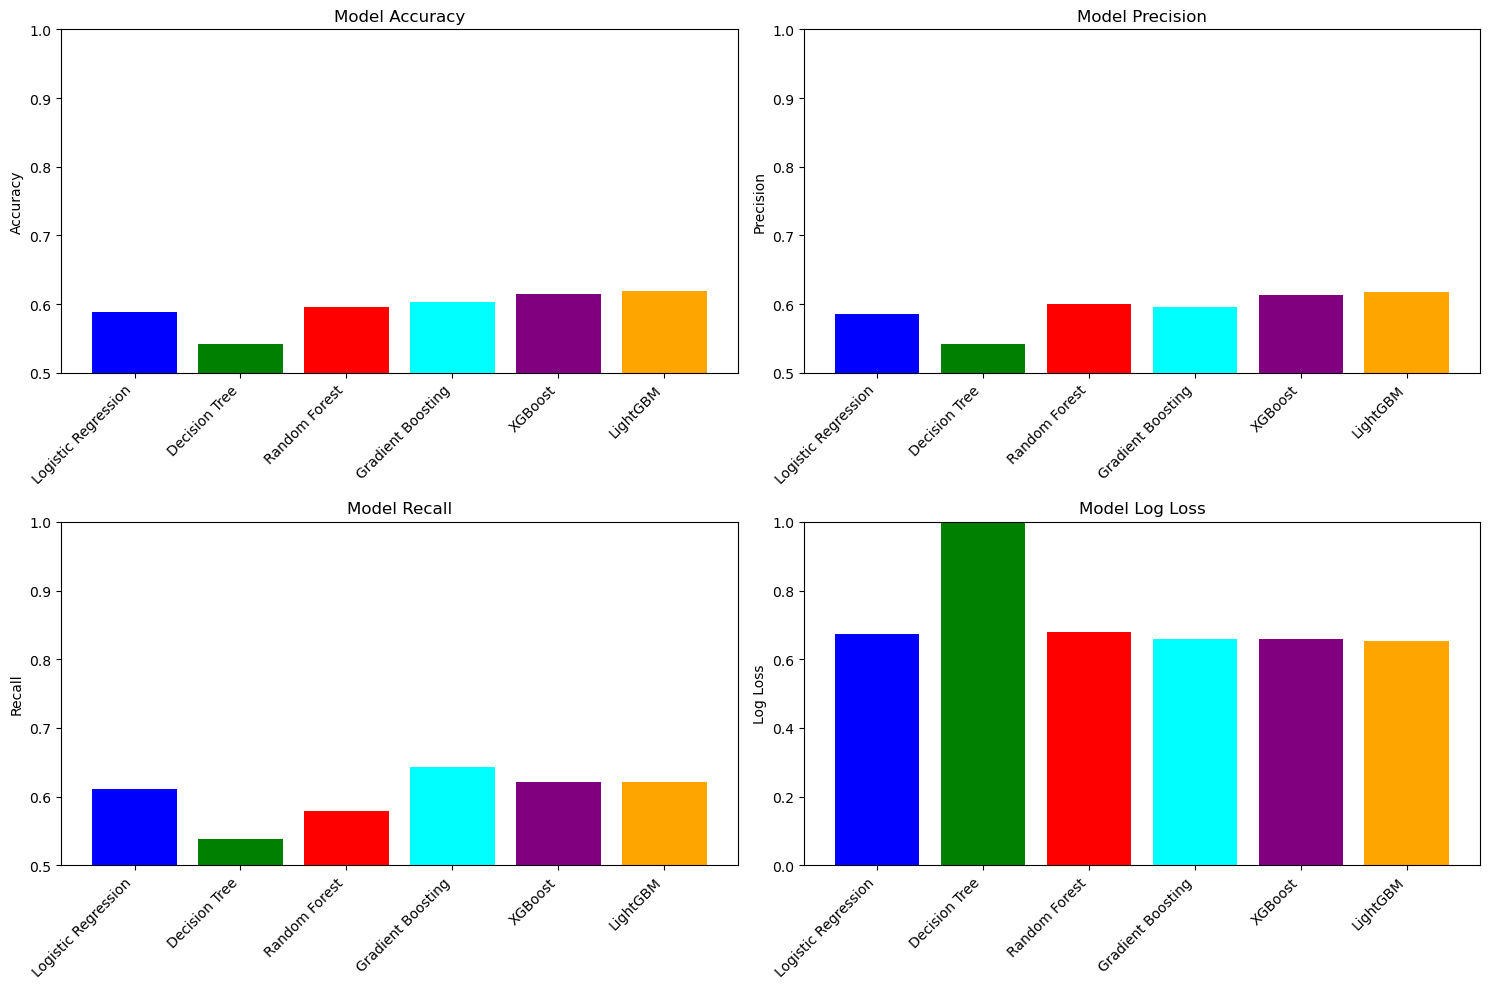

In [28]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 
               'Gradient Boosting', 'XGBoost', 'LightGBM']

# 모델 학습 결과 시각화
metrics = [accuracies, precisions, recalls, log_losses]
titles = ['Model Accuracy', 'Model Precision', 'Model Recall', 'Model Log Loss']
ylabels = ['Accuracy', 'Precision', 'Recall', 'Log Loss']
ylims = [(0.5, 1), (0.5, 1), (0.5, 1), (0, 1)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, ax in enumerate(axes.ravel()):
    ax.bar(model_names, metrics[i], color=['blue', 'green', 'red', 'cyan', 'purple', 'orange'])
    ax.set_title(titles[i])
    ax.set_ylabel(ylabels[i])
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim(ylims[i])
    
plt.tight_layout()
plt.show()
